In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.ndimage import zoom
from scipy.special import logsumexp
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from scipy.misc import face
import tensorflow.compat.v1 as tf_v1

import matplotlib.cm as cm

import os
from PIL import Image

import time

from scipy.ndimage import gaussian_filter

In [3]:
tf_v1.reset_default_graph()
tf_v1.disable_eager_execution()

In [4]:
# Name of the dataset
data_name = "flowers"
# Number of images to process:
M =1000 # Use 1000 to transform all the images in the flowers dataset
# Small batch size for the prediction of DeepGaze to avoid kernel restarting
u = 100 
# Parameters for auxiliary blurring:
H=100
sigma_max = 20

In [5]:
path_no_backup = "/nobackup/users/vianajr/saliency_xai/"
path_home = "/home/vianajr/saliency_xai/"

path_data = path_no_backup + f"data/{data_name}"
path_results = path_no_backup + f"results/{data_name}"
path_code = path_home + "code/"

path_tools_deep_gaze = path_code + "/tools_deep_gaze/"

# Check that all the paths exist:
for path in [path_results, 
             path_results+"/aux_ims", 
             path_results+"/dens_ims", 
             path_results+"/orig_images", 
             path_results+"/treat_ims",
             path_results+"/treat2_ims",
             path_results+"/Unet_ims",
             path_results+"/diff_ims",]:
    
    if not os.path.exists(path):
        os.makedirs(path)

In [6]:
# Sizes for the treated image needed:
if data_name == "flowers":
    size_1, size_2 = 256,256
    frac_1, frac_2 = 1, 1
    using_dpi = 69.2

In [7]:
files_raw = os.listdir(path_data) 

In [8]:
files_raw=files_raw[:M]

In [9]:
arr_ims = np.array([ np.asarray(image.resize((size_1, size_2))) for f in files_raw
                                                                if f != ".ipynb_checkpoints"
                                                                for image in [Image.open(os.path.join(path_data, f))]
                                                                if image.size[0]>=image.size[1]   ])

In [10]:
tot_ims = len(arr_ims)
print(tot_ims)

10


In [11]:
orig_im = arr_ims[0]
orig_im=orig_im/255.
orig_im.shape

(256, 256, 3)

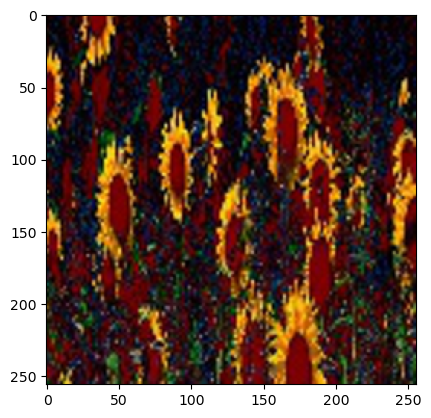

In [12]:
plt.imshow(orig_im)

In [13]:
# Load precomputed log density:
centerbias_template = np.load(path_tools_deep_gaze + '/centerbias.npy')  
# Rescale to match image size:
centerbias = zoom(centerbias_template, (size_1/1024, size_2/1024), order=0, mode='nearest')
# Renormalize log density:
centerbias -= logsumexp(centerbias)

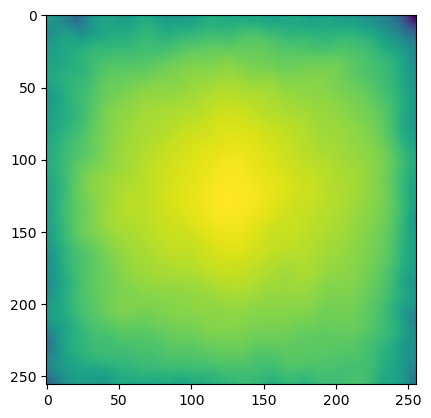

In [14]:
plt.imshow(centerbias)

The DeepGaze II model expects all input as 4d tensors of shape `BHWC` (i.e. batch-height-
width-channel). It takes two inputs:
A batch of images and a batch of centerbias log densities.

In [15]:
centerbias_data = centerbias[np.newaxis, :, :, np.newaxis] 

In [ ]:
# Import the deep gaze model from the tensorflow meta-graph file
check_point = path_tools_deep_gaze + '/DeepGazeII.ckpt'  # DeepGaze II
new_saver = tf_v1.train.import_meta_graph('{}.meta'.format(check_point))

input_tensor = tf_v1.get_collection('input_tensor')[0]
centerbias_tensor = tf_v1.get_collection('centerbias_tensor')[0]
log_density = tf_v1.get_collection('log_density')[0]
log_density_wo_centerbias = tf_v1.get_collection('log_density_wo_centerbias')[0]

In [17]:
# Create the batches of images:
batches_of_arr_ims = [ arr_ims[u*i:u*(i+1)] for i in range(int(np.ceil(tot_ims/u))) ]

In [ ]:
with tf_v1.Session() as sess:
    new_saver.restore(sess, check_point)
    
    batches_predictions = []
    
    for batch_ims in batches_of_arr_ims:
        batch_predictions = sess.run(log_density,{input_tensor: batch_ims,
                                                  centerbias_tensor: centerbias_data})
        
        batches_predictions.append(batch_predictions)
            
# Transform the batches predictions to the array you want:
arr_log_density_predictions = np.array([ in_val for val in batches_predictions for in_val in val])

In [19]:
arr_density_predictions = np.array ([ np.exp(sliced_mat) for sliced_mat in arr_log_density_predictions ])

In [20]:
print(arr_log_density_predictions.shape)
print(arr_density_predictions.shape)

(10, 256, 256, 1)
(10, 256, 256, 1)


In [21]:
dens_im = arr_density_predictions[0, :, :, 0]
log_dens_im = arr_log_density_predictions[0, :, :, 0]

(-0.5, 255.5, 255.5, -0.5)

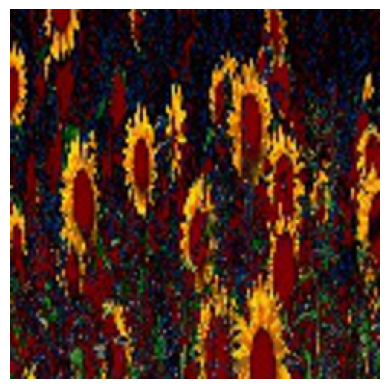

In [22]:
plt.imshow(orig_im)
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

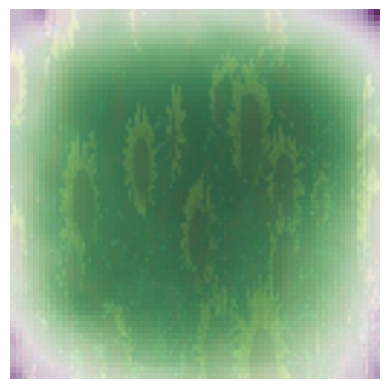

In [23]:
plt.imshow(orig_im, alpha=0.4)
m = plt.gca().matshow((log_dens_im), alpha=0.7, cmap=plt.cm.PRGn)
plt.axis('off')

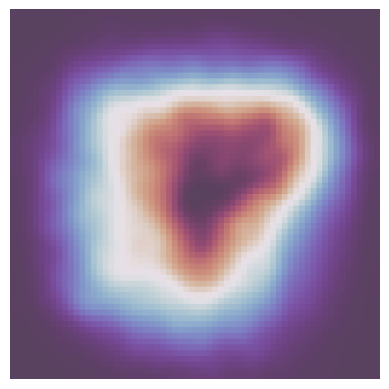

In [24]:
plt.axis('off')
m = plt.imshow(dens_im, alpha=0.8, cmap='twilight_shifted')

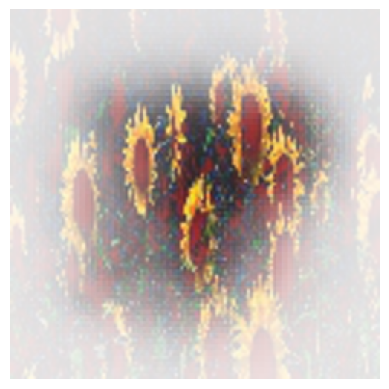

In [25]:
max_of_im = np.max(dens_im)
min_of_im = np.min(dens_im)
aux_alphas = (dens_im - min_of_im ) / (max_of_im - min_of_im)

alphas = 1/(1+np.exp(-4*(aux_alphas-0.5)))

orig_im = orig_im.transpose(2, 0, 1)
orig_im = np.append(orig_im, [alphas], axis=0)
orig_im = orig_im.transpose(1, 2, 0)

plt.axis('off')
plt.imshow(np.ones(orig_im.shape))
plt.imshow(orig_im)

In [26]:
# Blurring variables:
aux_simgas_xs = np.linspace(0,1,H)
sigmas = sigma_max * aux_simgas_xs**4

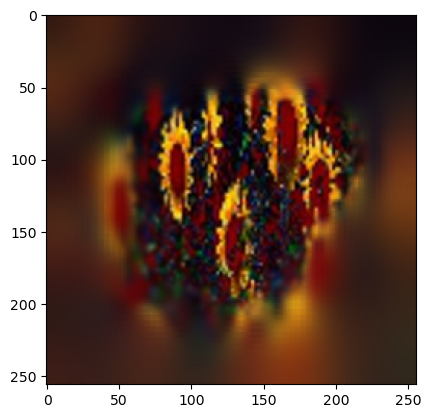

In [27]:
# Normalize density map:
min_dens = np.min(dens_im)
max_dens = np.max(dens_im)
norm_dens_im = (dens_im - min_dens)/(max_dens-min_dens)

# Reverse it and convert to ints for the scatter
reversed_norm_dens_im = 1-norm_dens_im
int_aux_im = (reversed_norm_dens_im*(H-1)).astype(np.int32)

# Apply layers of gaussian filter:
ims_filtered_r = np.array([ gaussian_filter(orig_im[:,:,0], sigma=sigma) for sigma in sigmas ])
ims_filtered_g = np.array([ gaussian_filter(orig_im[:,:,1], sigma=sigma) for sigma in sigmas ])
ims_filtered_b = np.array([ gaussian_filter(orig_im[:,:,2], sigma=sigma) for sigma in sigmas ])

# Select those layers that you want:
new_im = np.zeros((size_1,size_2,3))
for i in range(size_1):
    for j in range(size_2):
        new_im[i, j, 0] = ims_filtered_r[int_aux_im[i, j]][i, j]
        new_im[i, j, 1] = ims_filtered_g[int_aux_im[i, j]][i, j]
        new_im[i, j, 2] = ims_filtered_b[int_aux_im[i, j]][i, j]

plt.imshow(new_im)
plt.show()

### Get the desired transformation of all the images:

In [28]:
aux_arr_shape = arr_density_predictions.shape

(269, 269, 3)
(256, 256, 3)


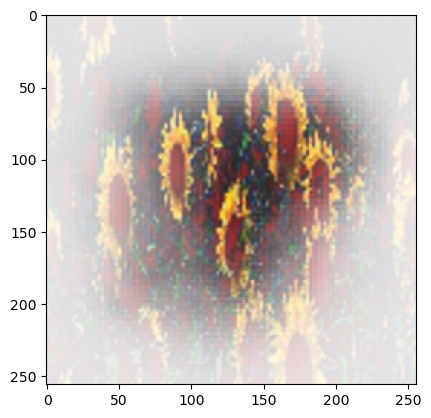

In [29]:
max_of_im = np.max(dens_im)
min_of_im = np.min(dens_im)
aux_alphas = (dens_im - min_of_im ) / (max_of_im - min_of_im)
alphas = 1/(1+np.exp(-4*(aux_alphas-0.5)))
            
orig_im = arr_ims[0]/255.
orig_im = orig_im.transpose(2, 0, 1)
orig_im = np.append(orig_im, [alphas], axis=0)
orig_im = orig_im.transpose(1, 2, 0)

plt.axis('off')
plt.imshow(np.ones(orig_im.shape))
plt.imshow(orig_im)

plt.savefig(path_results + '/reference.png', dpi= using_dpi, bbox_inches='tight', format='png')
plt.close()

read_arr = np.asarray(Image.open(path_results + '/reference.png'))[:,:,:3]

filter_rows = read_arr[:,int(aux_arr_shape[2]/2),0] != 255
filter_cols = read_arr[int(aux_arr_shape[1]/2),:,0] != 255

aux_1 =   np.transpose(read_arr[filter_rows], (1, 0, 2))
new_arr = np.transpose(aux_1[filter_cols], (1, 0, 2))
new_arr = new_arr/255.

plt.imshow(new_arr)

print(read_arr.shape)
print(new_arr.shape)

In [ ]:
ranger = list(range(len(arr_ims)))

t_0 = time.time()

dict_orig_ims = {}
dict_dens_ims = {}
dict_treat_ims = {}
dict_treat2_ims = {}
    

for i, im_i, aux_dens_i in zip(ranger, arr_ims, arr_density_predictions):

    print(i)
    
    # First:
    dens_i = aux_dens_i[:, :, 0]
    im_i=im_i/255.

    # Save the original image and the density prediction images:  
    plt.axis('off')
    plt.imshow(im_i)
    plt.savefig(path_results + f'/orig_ims/orig_{i}.png', dpi= using_dpi, bbox_inches='tight', format='png')
    plt.close()

    plt.axis('off')
    plt.imshow(dens_i, alpha=0.8, cmap='twilight_shifted')
    plt.savefig(path_results + f'/dens_ims/dens_{i}.png', dpi= using_dpi, bbox_inches='tight', format='png')
    plt.close()  

    # Processing:
    max_of_im = np.max(dens_i)
    min_of_im = np.min(dens_i)
    aux_alphas = (dens_i - min_of_im ) / (max_of_im - min_of_im)
    alphas = 1/(1+np.exp(-4*(aux_alphas-0.5)))

    # Temporal auxiliary image:
    aug_im_i = im_i.transpose(2, 0, 1)
    aug_im_i = np.append(aug_im_i, [alphas], axis=0)
    aug_im_i = aug_im_i.transpose(1, 2, 0)

    plt.axis('off')
    plt.imshow(np.ones(aug_im_i.shape))
    plt.imshow(aug_im_i)
    plt.savefig(path_results + f'/aux_ims/aux_{i}.png', dpi= using_dpi, bbox_inches='tight', format='png')
    plt.close()
    read_im = np.asarray(Image.open(path_results + f'/aux_ims/aux_{i}.png'))[:,:,:3]


    # Treated image 1:
    aux_1 =  np.transpose(read_im[filter_rows], (1, 0, 2))
    new_im = np.transpose(aux_1[filter_cols], (1, 0, 2))
    new_im = new_im/255.

    plt.axis('off')
    plt.imshow(new_im)
    plt.savefig(path_results + f'/treat_ims/treat_{i}.png', dpi= using_dpi, bbox_inches='tight', format='png')
    plt.close()   
  
    
    # Treated Image 2:
    
    # Normalize density map:
    min_dens = np.min(dens_i)
    max_dens = np.max(dens_i)
    norm_dens_i = (dens_i - min_dens)/(max_dens-min_dens)

    # Reverse it and convert to ints for the scatter
    reversed_norm_dens_i = 1-norm_dens_i
    int_aux_im = (reversed_norm_dens_i*(H-1)).astype(np.int32)

    # Apply layers of gaussian filter:
    ims_filtered_r = np.array([ gaussian_filter(im_i[:,:,0], sigma=sigma) for sigma in sigmas ])
    ims_filtered_g = np.array([ gaussian_filter(im_i[:,:,1], sigma=sigma) for sigma in sigmas ])
    ims_filtered_b = np.array([ gaussian_filter(im_i[:,:,2], sigma=sigma) for sigma in sigmas ])

    # Select those layers that you want:
    treat2_im = np.zeros((size_1,size_2,3))
    for a in range(size_1):
        for b in range(size_2):
            treat2_im[a, b, 0] = ims_filtered_r[int_aux_im[a, b]][a, b]
            treat2_im[a, b, 1] = ims_filtered_g[int_aux_im[a, b]][a, b]
            treat2_im[a, b, 2] = ims_filtered_b[int_aux_im[a, b]][a, b]
    
    
    plt.axis('off')
    plt.imshow(treat2_im)
    plt.savefig(path_results + f'/treat2_ims/treat2_{i}.png', dpi= using_dpi, bbox_inches='tight', format='png')
    plt.close()  

        
        
    # Store the remainder:
    dict_orig_ims[i]=im_i
    dict_dens_ims[i]=dens_i
    dict_treat_ims[i]=new_im
    dict_treat2_ims[i]=treat2_im
    
    
# Save all the data:
np.savez(path_results + '/results.npz', var_orig_ims=np.array(list(dict_orig_ims.values())), 
                                        var_dens_ims=np.array(list(dict_dens_ims.values())),
                                        var_treat_ims=np.array(list(dict_treat_ims.values())),
                                        var_treat2_ims=np.array(list(dict_treat2_ims.values())),
        )

    
print(time.time()-t_0)

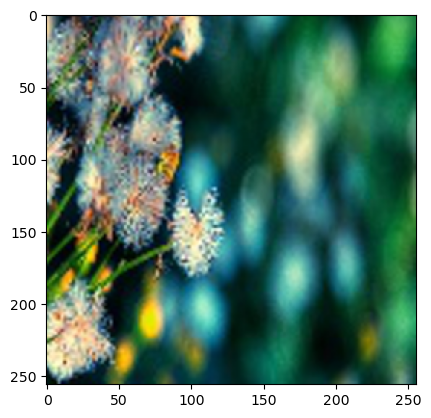

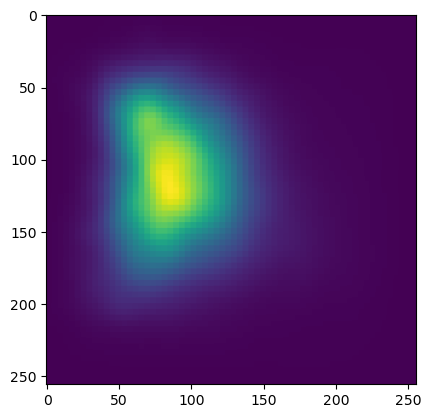

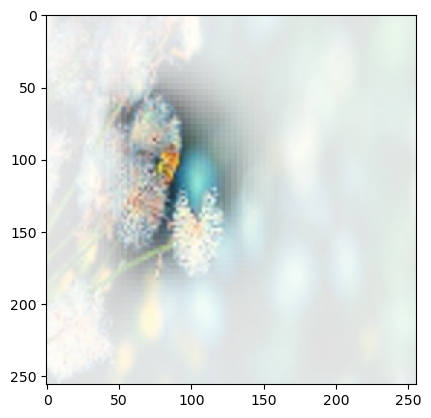

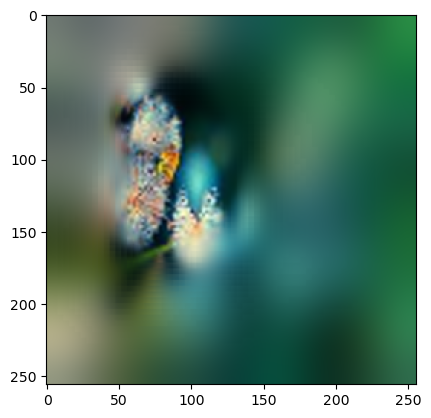

In [31]:
data = np.load(path_results + '/results.npz', allow_pickle=True)
plt.figure()
plt.imshow(data['var_orig_ims'][7])
plt.figure()
plt.imshow(data['var_dens_ims'][7])
plt.figure()
plt.imshow(data['var_treat_ims'][7])
plt.figure()
plt.imshow(data['var_treat2_ims'][7])